In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from statistics import mean, stdev
import time
from math import ceil

# data partition
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

# metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.feature_selection import RFE

# embedded methods
from sklearn.linear_model import LassoCV

# oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Kfold
from sklearn.model_selection import StratifiedKFold

# scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
# open the train dataset
df = pd.read_csv('data/train.csv')
df.head(3)

Access_ID       Date  AccountMng_Pages  AccountMng_Duration  FAQ_Pages  \
0  102863333  21-Mar-20                 0                  0.0          0   
1  103117814  20-May-20                 0                  0.0          0   
2  103201891   4-Dec-20                 0                  0.0          0   

   FAQ_Duration  Product_Pages  Product_Duration  GoogleAnalytics_BounceRate  \
0           0.0              3              64.0                      0.0000   
1           0.0             23             684.5                      0.0217   
2           0.0              8              95.0                      0.0250   

   GoogleAnalytics_ExitRate  GoogleAnalytics_PageValue       OS  Browser  \
0                    0.0667                        0.0   MacOSX        2   
1                    0.0449                        0.0  Windows        2   
2                    0.0583                        0.0  Windows        4   

    Country  Type_of_Traffic Type_of_Visitor  Buy  
0  Portugal                1        Returner    0  
1    France                6        Returner    0  
2     Italy                1        Returner    0

In [3]:
# set the index as the Access_ID
df.set_index('Access_ID', inplace = True)
df.head(3)

Date  AccountMng_Pages  AccountMng_Duration  FAQ_Pages  \
Access_ID                                                                
102863333  21-Mar-20                 0                  0.0          0   
103117814  20-May-20                 0                  0.0          0   
103201891   4-Dec-20                 0                  0.0          0   

           FAQ_Duration  Product_Pages  Product_Duration  \
Access_ID                                                  
102863333           0.0              3              64.0   
103117814           0.0             23             684.5   
103201891           0.0              8              95.0   

           GoogleAnalytics_BounceRate  GoogleAnalytics_ExitRate  \
Access_ID                                                         
102863333                      0.0000                    0.0667   
103117814                      0.0217                    0.0449   
103201891                      0.0250                    0.0583   

           GoogleAnalytics_PageValue       OS  Browser   Country  \
Access_ID                                                          
102863333                        0.0   MacOSX        2  Portugal   
103117814                        0.0  Windows        2    France   
103201891                        0.0  Windows        4     Italy   

           Type_of_Traffic Type_of_Visitor  Buy  
Access_ID                                        
102863333                1        Returner    0  
103117814                6        Returner    0  
103201891                1        Returner    0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 102863333 to 798444008
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        9999 non-null   object 
 1   AccountMng_Pages            9999 non-null   int64  
 2   AccountMng_Duration         9999 non-null   float64
 3   FAQ_Pages                   9999 non-null   int64  
 4   FAQ_Duration                9999 non-null   float64
 5   Product_Pages               9999 non-null   int64  
 6   Product_Duration            9999 non-null   float64
 7   GoogleAnalytics_BounceRate  9999 non-null   float64
 8   GoogleAnalytics_ExitRate    9999 non-null   float64
 9   GoogleAnalytics_PageValue   9999 non-null   float64
 10  OS                          9999 non-null   object 
 11  Browser                     9999 non-null   int64  
 12  Country                     9999 non-null   object 
 13  Type_of_Traffic     

In [5]:
# data types transformation
# Converting Date type from object to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

In [6]:
df.describe().T

count         mean          std  min       25%  \
AccountMng_Pages            9999.0     2.324232     3.340676  0.0    0.0000   
AccountMng_Duration         9999.0    81.205854   179.715545  0.0    0.0000   
FAQ_Pages                   9999.0     0.508051     1.279390  0.0    0.0000   
FAQ_Duration                9999.0    34.559101   139.796989  0.0    0.0000   
Product_Pages               9999.0    31.685869    44.550277  0.0    7.0000   
Product_Duration            9999.0  1199.769430  1958.276304  0.0  183.5625   
GoogleAnalytics_BounceRate  9999.0     0.022305     0.048776  0.0    0.0000   
GoogleAnalytics_ExitRate    9999.0     0.043181     0.048845  0.0    0.0143   
GoogleAnalytics_PageValue   9999.0     5.963120    18.753626  0.0    0.0000   
Browser                     9999.0     2.352535     1.715698  1.0    2.0000   
Type_of_Traffic             9999.0     3.957496     3.675159  1.0    2.0000   
Buy                         9999.0     0.155216     0.362128  0.0    0.0000   

                                 50%         75%         max  
AccountMng_Pages              1.0000     4.00000     27.0000  
AccountMng_Duration           7.5000    92.20835   3398.7500  
FAQ_Pages                     0.0000     0.00000     24.0000  
FAQ_Duration                  0.0000     0.00000   2549.3750  
Product_Pages                18.0000    38.00000    705.0000  
Product_Duration            599.0000  1470.27080  63973.5222  
GoogleAnalytics_BounceRate    0.0032     0.01680      0.2000  
GoogleAnalytics_ExitRate      0.0251     0.05000      0.2000  
GoogleAnalytics_PageValue     0.0000     0.00000    361.7637  
Browser                       2.0000     2.00000     13.0000  
Type_of_Traffic               2.0000     4.00000     15.0000  
Buy                           0.0000     0.00000      1.0000

#### Observations:
- the dataset don't have null values
- it has outliers in some features - need to explore and solve them
- it has 9.999 observations and 15 features (9 numerical and 6 categorical)
- the dependent variable is 'Buy'

## Split into train and val dataset
- all the preprocessing steps will be do into the train dataset

In [7]:
X = df.drop('Buy', axis=1)
y = df['Buy']

In [8]:
# split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=5, stratify=y)

In [9]:
X_train.columns

Index(['Date', 'AccountMng_Pages', 'AccountMng_Duration', 'FAQ_Pages',
       'FAQ_Duration', 'Product_Pages', 'Product_Duration',
       'GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate',
       'GoogleAnalytics_PageValue', 'OS', 'Browser', 'Country',
       'Type_of_Traffic', 'Type_of_Visitor'],
      dtype='object')

In [10]:
# Define metric and non-metric features
non_metric_features = ['Date', 'OS', 'Browser', 'Country', 'Type_of_Traffic', 'Type_of_Visitor']
metric_features = X_train.columns.drop(non_metric_features).to_list()

In [11]:
non_metric_features

['Date', 'OS', 'Browser', 'Country', 'Type_of_Traffic', 'Type_of_Visitor']

In [12]:
metric_features

['AccountMng_Pages',
 'AccountMng_Duration',
 'FAQ_Pages',
 'FAQ_Duration',
 'Product_Pages',
 'Product_Duration',
 'GoogleAnalytics_BounceRate',
 'GoogleAnalytics_ExitRate',
 'GoogleAnalytics_PageValue']

## Preprocessing

- Outliers

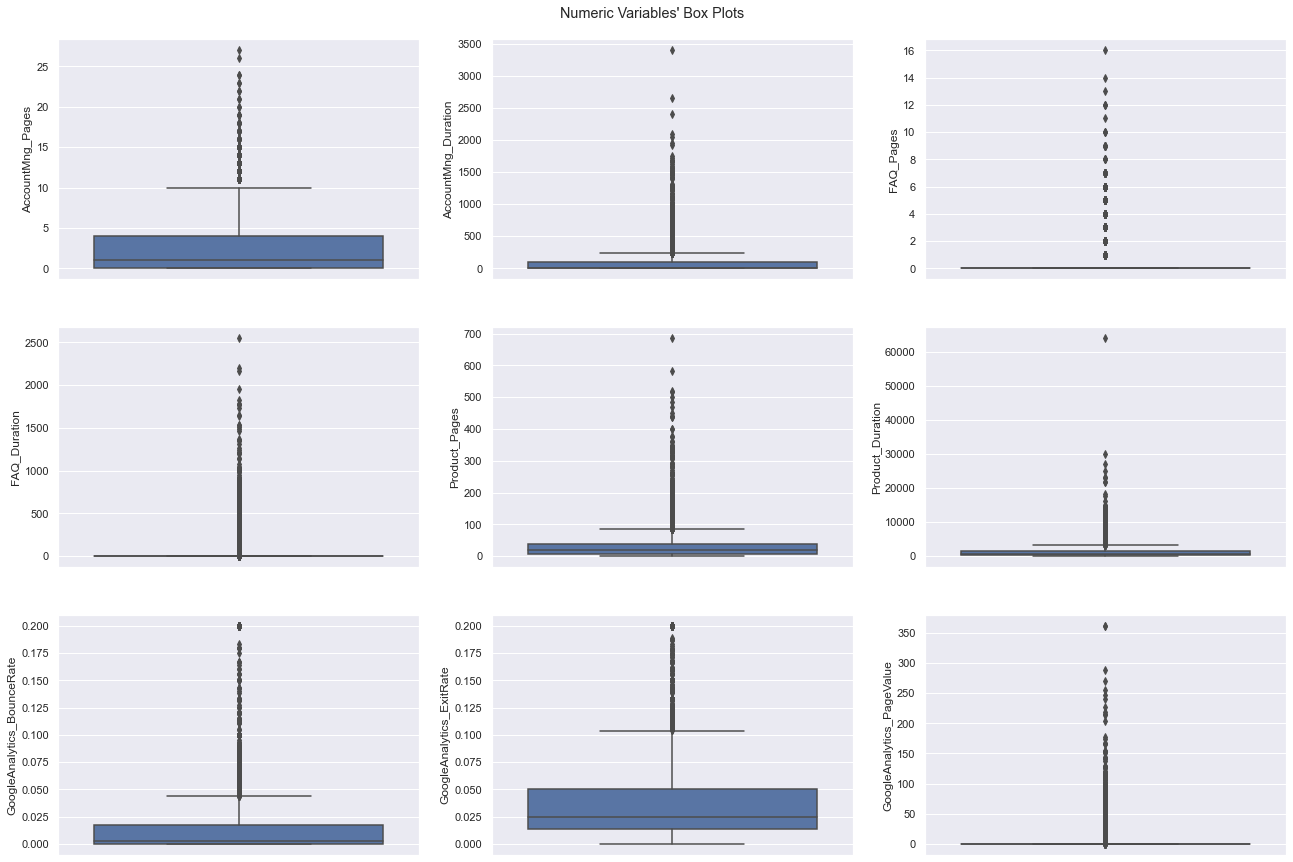

In [13]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(22, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(y=X_train[feat], ax=ax)
    #ax.set_title(feat, y=-0.16)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title, y=0.91)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_boxplots.png'), dpi=200)
plt.show()

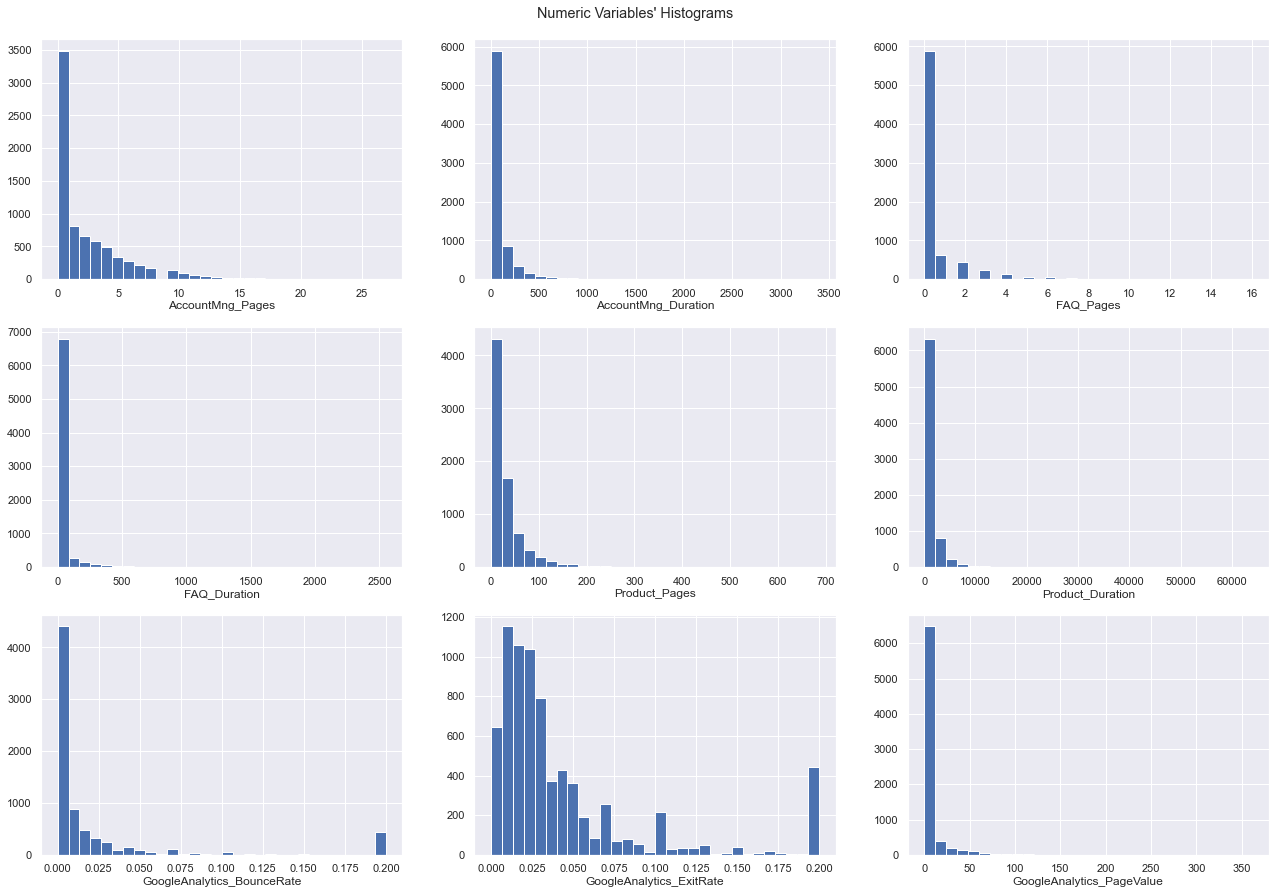

In [14]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(22, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(X_train[feat], bins=30)
    ax.set_title(feat, y=-0.15)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title, y=0.91)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
plt.show()

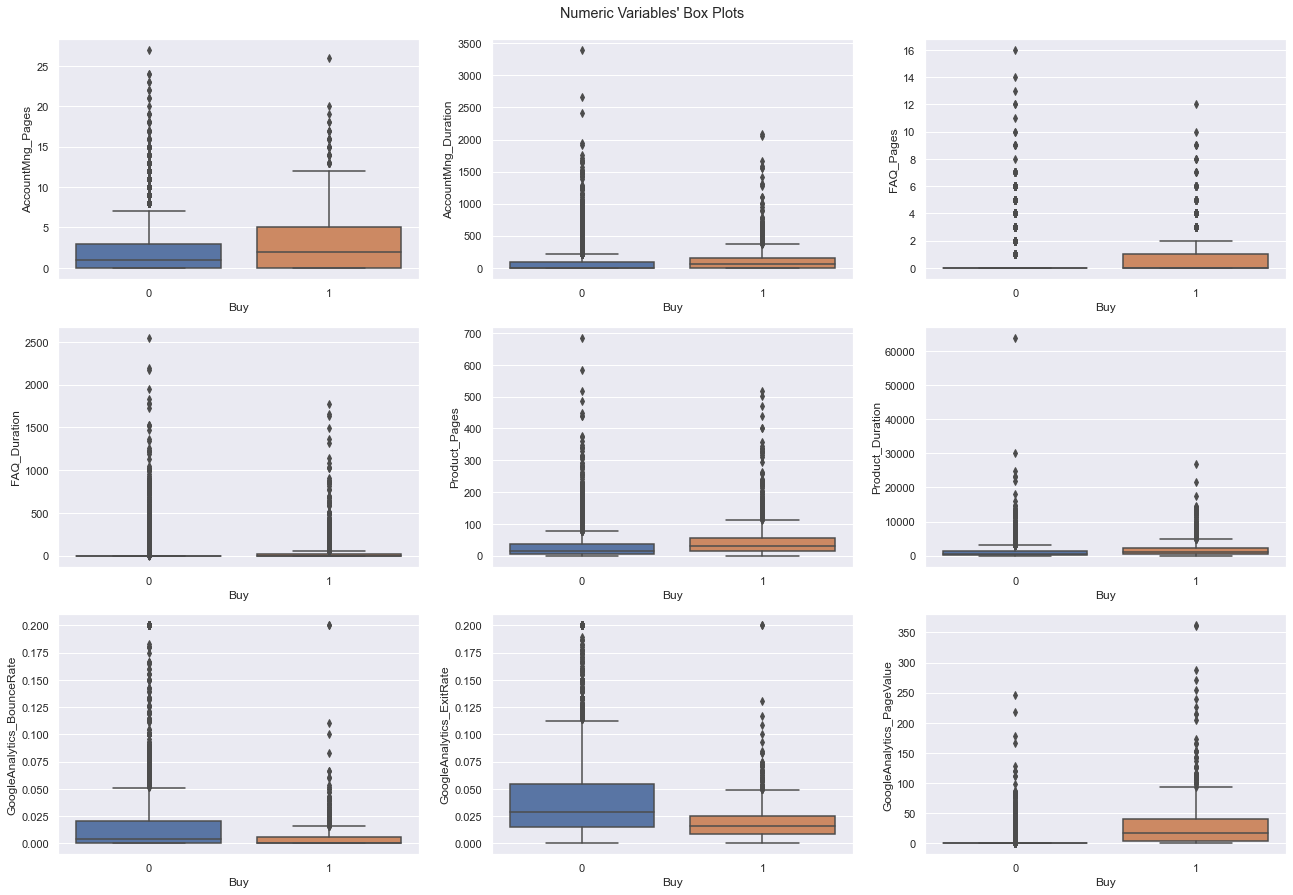

In [15]:
# All Numeric Variables' Box Plots in one figure - with the dependent variable
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(22, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(y=X_train[feat], x=y_train, ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title, y=0.91)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_boxplots.png'), dpi=200)
plt.show()

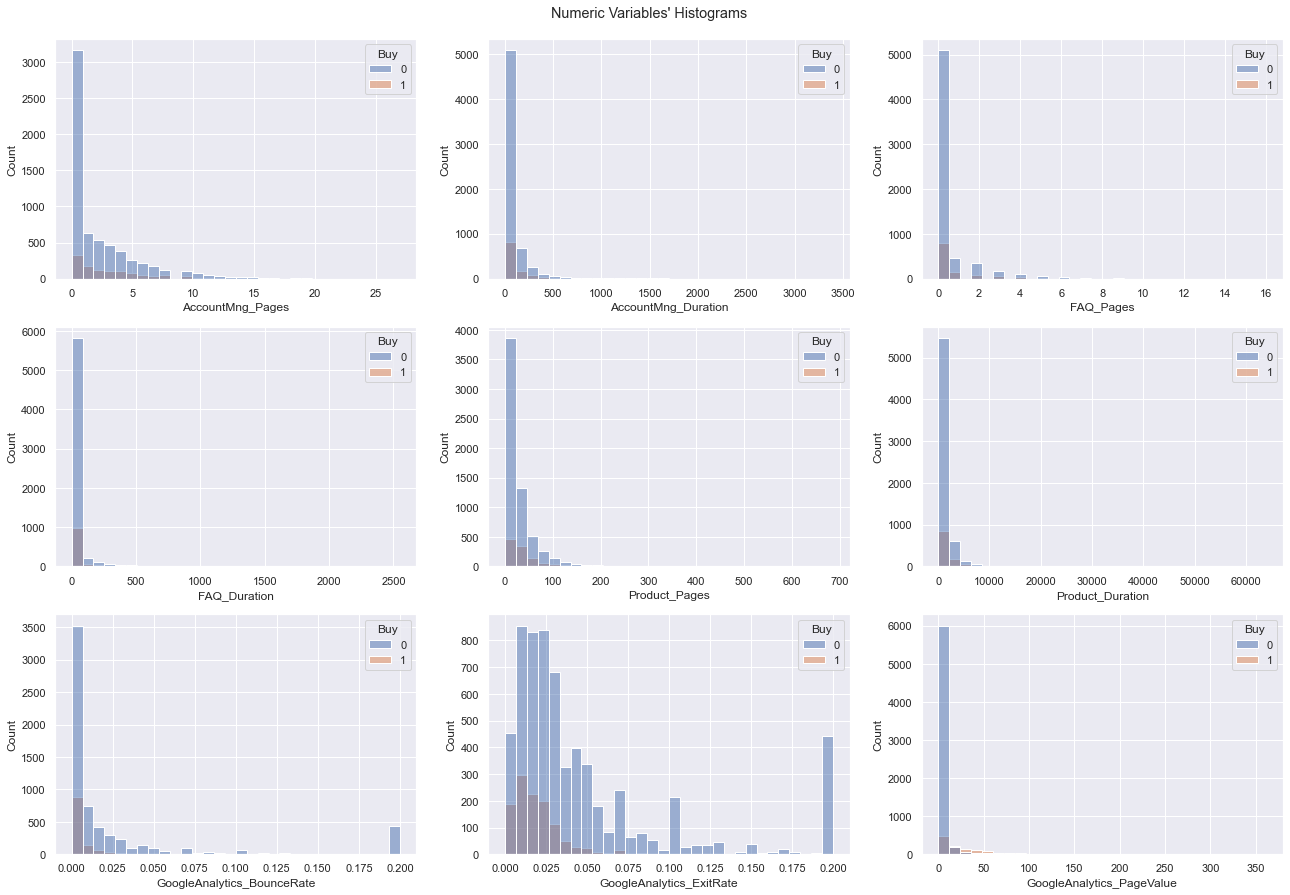

In [16]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(22, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.histplot(data=X_train, x=feat, hue=y_train, ax=ax, bins=30)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title, y=0.91)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
plt.show()

Observations:
- the dataset has outliers in all of the numeric features
- the data is right skewed in all of the numeric features, there is a lot of zero values in all features except in 'GoogleAnalytics_ExitRate'
- the distribution of the observations that didn't buy the products is very similar to those that bought the product. This means that it can be difficult to the model to learn the differences of these two groups

In [17]:
# Define trashold for outliers - conservative method

filters1 = (
    (X_train['AccountMng_Duration']<=2000)
    &
    (X_train['FAQ_Duration']<=2000)
    &
    (X_train['Product_Pages']<=650)
    &
    (X_train['Product_Duration']<=50000)
    &
    (X_train['GoogleAnalytics_PageValue']<=350)
)

train_concat = pd.concat([X_train, y_train], axis=1)

df_1 = train_concat[filters1]

print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / train_concat.shape[0], 4))

train_concat = train_concat[filters1]

Percentage of data kept after removing outliers: 0.9987


In [18]:
X_train = train_concat.drop('Buy', axis=1)
y_train = train_concat['Buy']

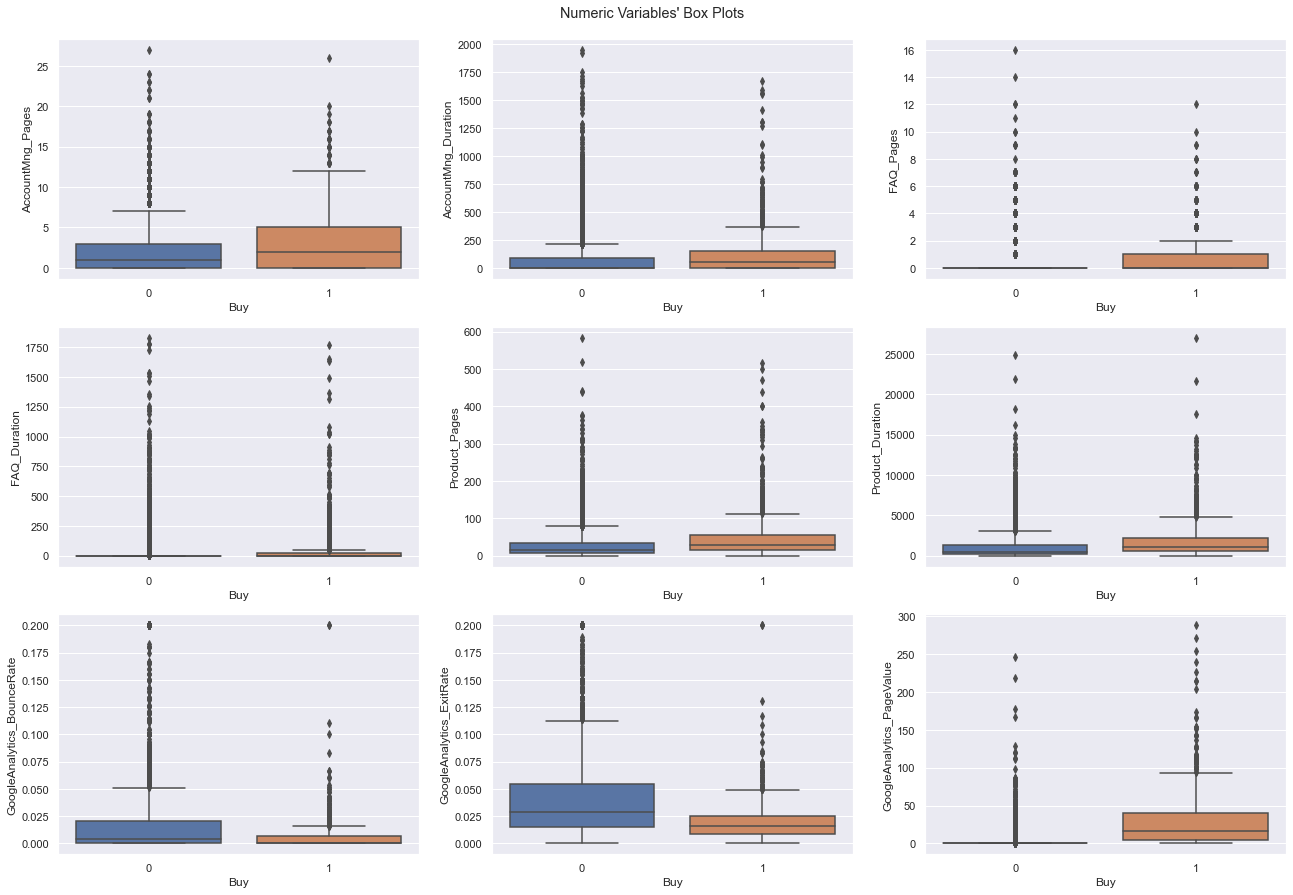

In [19]:
# After outliers removal
# All Numeric Variables' Box Plots in one figure - with the dependent variable
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(22, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(y=X_train[feat], x=y_train, ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title, y=0.91)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_boxplots.png'), dpi=200)
plt.show()

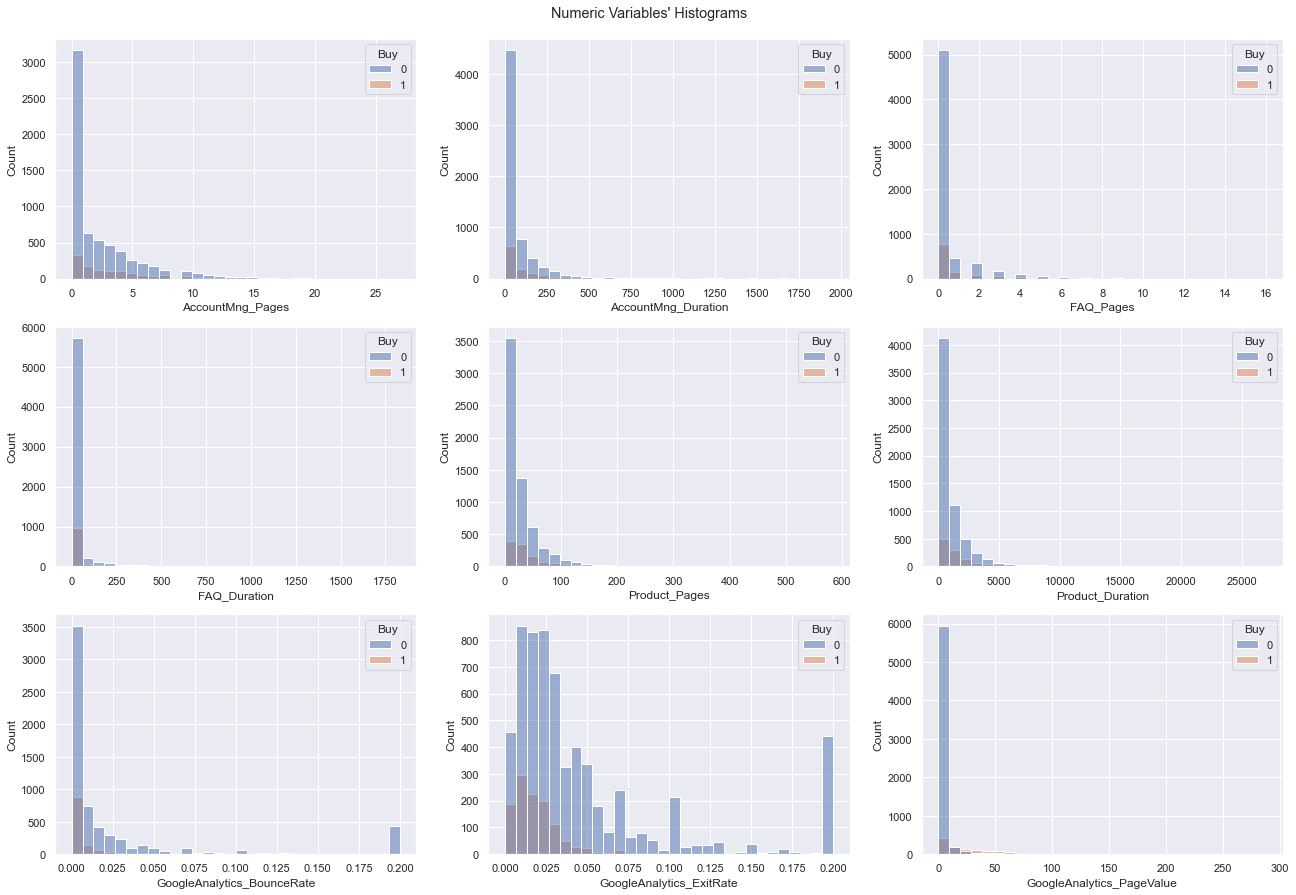

In [20]:
# After outliers removal
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(22, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.histplot(data=X_train, x=feat, hue=y_train, ax=ax, bins=30)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title, y=0.91)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
plt.show()

## Feature Selection

- Correlation

In [21]:
# define the fuction for correlation's heatmap 
def cor_heatmap(cor, ax):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1', ax=ax)
    plt.show()

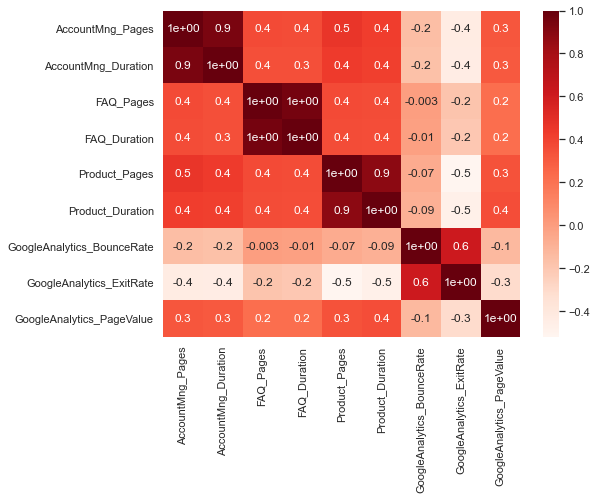

<Figure size 864x720 with 0 Axes>

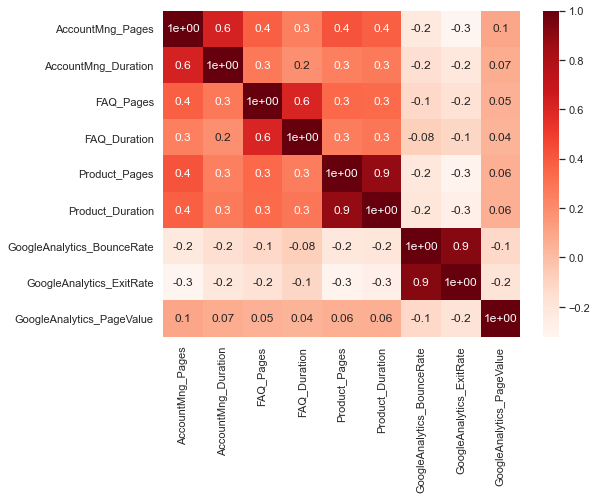

<Figure size 864x720 with 0 Axes>

In [22]:
#build correlation matrix
# method - pearson - feature and target/ linear relation
cor_pearson = X_train[metric_features].corr(method='pearson')

# method - spearman - rank correlation, ordering/ not linear relation
cor_spearman = X_train[metric_features].corr(method ='spearman')

# plot the correlations
fig, ax1 = plt.subplots(1,1, figsize=(8,6))
cor_heatmap(cor_spearman, ax1)

fig, ax1 = plt.subplots(1,1, figsize=(8,6))
cor_heatmap(cor_pearson, ax1)

Observations:
- Features highly correlated (keep only one):
    - __'AccountMng_Pages'__ and __'AccountMng_Duration'__ (Number of pages visited and total amount of time spent by the user - account management related pages)
    - __'FAQ_Pages'__ and __'FAQ_Duration'__ (Number of pages visited and total amount of time spent by the user - FAQ related pages)
    - __'Product_Pages'__ and __'Product_Duration'__ (Number of pages visited and total amount of time spent by the user - Product related pages)
    - __'GoogleAnalytics_BounceRate'__ and __'GoogleAnalytics_ExitRate'__ (Bounce and exit rate, both explains the the exit rate of the pages visited by the user)

In [23]:
X_train.drop(['AccountMng_Duration', 'FAQ_Duration', 'Product_Duration', 'GoogleAnalytics_ExitRate'], axis=1, inplace=True)

In [24]:
X_train.columns

Index(['Date', 'AccountMng_Pages', 'FAQ_Pages', 'Product_Pages',
       'GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'OS',
       'Browser', 'Country', 'Type_of_Traffic', 'Type_of_Visitor'],
      dtype='object')

In [25]:
# define new metric and non-metric features
# Define metric and non-metric features
non_metric_features = ['Date', 'OS', 'Browser', 'Country', 'Type_of_Traffic', 'Type_of_Visitor']
metric_features = X_train.columns.drop(non_metric_features).to_list()

- Scale numeric values

In [26]:
# Separate metric and non-metric features before scaling
# Train dataset
X_train_num = X_train[metric_features]
X_train_cat = X_train[non_metric_features]

# Validation dataset
X_val_num = X_val[metric_features]
X_val_cat = X_val[non_metric_features]

In [27]:
# Power Transformation - this one was the better transformation method{‘yeo-johnson’},
# "A power transform will make the probability distribution of a variable more Gaussian."
# "This is often described as removing a skew in the distribution, stabilizing the variance of the distribution."

power = PowerTransformer().fit(X_train_num)

X_train_num_power = power.transform(X_train_num)
# Convert the array to a pandas dataframe
X_train_num_power = pd.DataFrame(X_train_num_power, columns = X_train_num.columns).set_index(X_train.index)
X_train_num_power.head(3)

AccountMng_Pages  FAQ_Pages  Product_Pages  \
Access_ID                                               
708079592          0.834211  -0.522127       1.451751   
426312699          0.551204   1.812977       0.127755   
156527868         -0.994652  -0.522127       0.560716   

           GoogleAnalytics_BounceRate  GoogleAnalytics_PageValue  
Access_ID                                                         
708079592                   -0.798198                  -0.532968  
426312699                   -0.798198                  -0.532968  
156527868                   -0.798198                  -0.532968

In [28]:
# transform validaton dataset
X_val_num_power = power.transform(X_val_num)
# Convert the array to a pandas dataframe
X_val_num_power = pd.DataFrame(X_val_num_power, columns = X_val_num.columns).set_index(X_val.index)
X_val_num_power.head(3)

AccountMng_Pages  FAQ_Pages  Product_Pages  \
Access_ID                                               
247273702          0.076531  -0.522127       0.586932   
373594901         -0.994652  -0.522127      -0.009645   
273153081          1.027367  -0.522127       0.612429   

           GoogleAnalytics_BounceRate  GoogleAnalytics_PageValue  
Access_ID                                                         
247273702                   -0.798198                  -0.532968  
373594901                   -0.798198                  -0.532968  
273153081                   -0.798198                  -0.532968

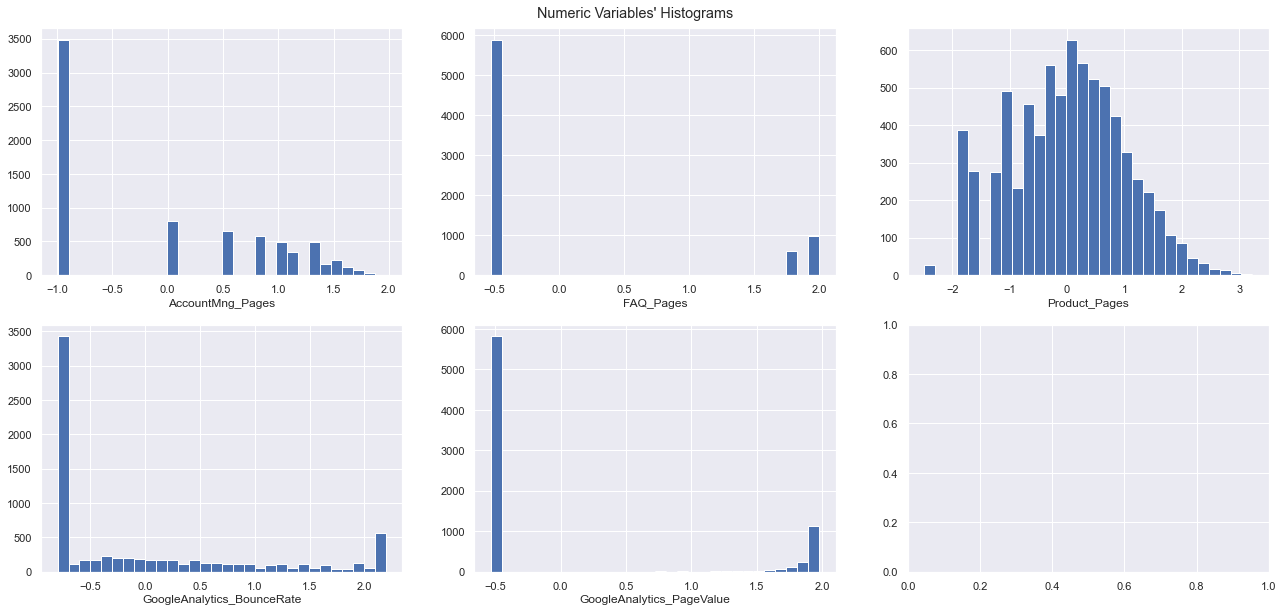

In [29]:
# After Power Transformation
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(22, 10))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(X_train_num_power[feat], bins=30)
    ax.set_title(feat, y=-0.15)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title, y=0.91)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
plt.show()

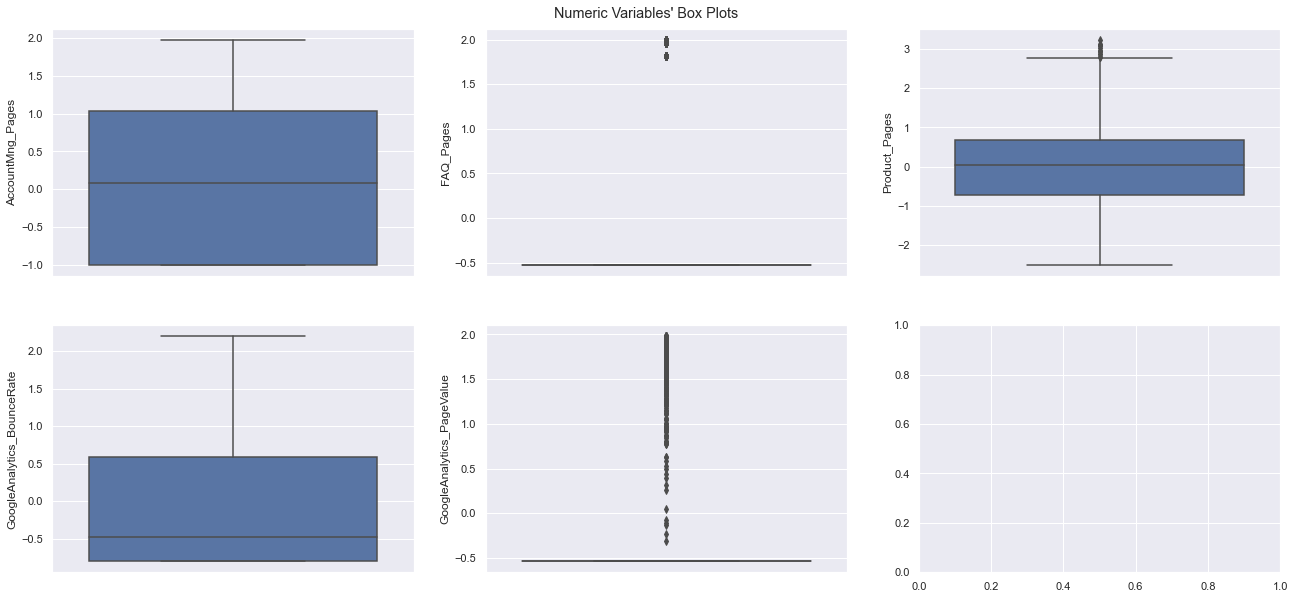

In [30]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(22, 10))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(y=X_train_num_power[feat], ax=ax)
    #ax.set_title(feat, y=-0.16)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title, y=0.91)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_boxplots.png'), dpi=200)
plt.show()

- Chi-Square for categorical data

In [31]:
df['Buy'].value_counts()

0    8447
1    1552
Name: Buy, dtype: int64

In [32]:
# define the function to verufy if there is an association between categorical variables
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [33]:
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Date is IMPORTANT for Prediction
OS is IMPORTANT for Prediction
Browser is IMPORTANT for Prediction
Country is NOT an important predictor. (Discard Country from model)
Type_of_Traffic is IMPORTANT for Prediction
Type_of_Visitor is IMPORTANT for Prediction


In [34]:
# concat numeric and categorical data after Power Transformation - train dataset
X_train_power = pd.concat([X_train_num_power, X_train_cat], axis=1)
X_train_power.head(3)

AccountMng_Pages  FAQ_Pages  Product_Pages  \
Access_ID                                               
708079592          0.834211  -0.522127       1.451751   
426312699          0.551204   1.812977       0.127755   
156527868         -0.994652  -0.522127       0.560716   

           GoogleAnalytics_BounceRate  GoogleAnalytics_PageValue       Date  \
Access_ID                                                                     
708079592                   -0.798198                  -0.532968 2020-11-06   
426312699                   -0.798198                  -0.532968 2020-03-26   
156527868                   -0.798198                  -0.532968 2020-11-24   

                OS  Browser         Country  Type_of_Traffic Type_of_Visitor  
Access_ID                                                                     
708079592  Windows        2           Spain                2      New_Access  
426312699   MacOSX        2           Spain                1        Returner  
156527868  Windows        2  United Kingdom                2        Returner

In [35]:
# drop Country and Date from categorical features
X_train_power.drop(['Date', 'Country'], axis=1, inplace=True)
X_train_power.head(3)

AccountMng_Pages  FAQ_Pages  Product_Pages  \
Access_ID                                               
708079592          0.834211  -0.522127       1.451751   
426312699          0.551204   1.812977       0.127755   
156527868         -0.994652  -0.522127       0.560716   

           GoogleAnalytics_BounceRate  GoogleAnalytics_PageValue       OS  \
Access_ID                                                                   
708079592                   -0.798198                  -0.532968  Windows   
426312699                   -0.798198                  -0.532968   MacOSX   
156527868                   -0.798198                  -0.532968  Windows   

           Browser  Type_of_Traffic Type_of_Visitor  
Access_ID                                            
708079592        2                2      New_Access  
426312699        2                1        Returner  
156527868        2                2        Returner

In [36]:
# concat numeric and categorical data after Power Transformation - val dataset
X_val_power = pd.concat([X_val_num_power, X_val_cat], axis=1)
X_val_power.head(3)

# drop Country and Date from categorical features
X_val_power.drop(['Date', 'Country'], axis=1, inplace=True)
X_val_power.head(3)

AccountMng_Pages  FAQ_Pages  Product_Pages  \
Access_ID                                               
247273702          0.076531  -0.522127       0.586932   
373594901         -0.994652  -0.522127      -0.009645   
273153081          1.027367  -0.522127       0.612429   

           GoogleAnalytics_BounceRate  GoogleAnalytics_PageValue       OS  \
Access_ID                                                                   
247273702                   -0.798198                  -0.532968  Android   
373594901                   -0.798198                  -0.532968  Windows   
273153081                   -0.798198                  -0.532968  Windows   

           Browser  Type_of_Traffic Type_of_Visitor  
Access_ID                                            
247273702        1                2        Returner  
373594901        2                2      New_Access  
273153081        2                2      New_Access

In [37]:
X_train_power.shape

(7489, 9)

In [38]:
X_val_power.shape

(2500, 9)

- Create dummy variables

In [39]:
# create dummy variables - 'OS', 'Browser', 'Type_of_Traffic', 'Type_of_Visitor' - Train Dataset

# 'OS'
X_train_power = pd.get_dummies(X_train_power, columns = ['OS'], drop_first=True)

# 'Browser'
X_train_power = pd.get_dummies(X_train_power, columns = ['Browser'], drop_first=True)

# 'Type_of_Traffic'
X_train_power = pd.get_dummies(X_train_power, columns = ['Type_of_Traffic'], drop_first=True)

# 'Type_of_Visitor'
X_train_power = pd.get_dummies(X_train_power, columns = ['Type_of_Visitor'], drop_first=True)

In [40]:
X_train_power

AccountMng_Pages  FAQ_Pages  Product_Pages  \
Access_ID                                               
708079592          0.834211  -0.522127       1.451751   
426312699          0.551204   1.812977       0.127755   
156527868         -0.994652  -0.522127       0.560716   
414839270          0.076531   1.812977       0.447739   
569787208         -0.994652  -0.522127       0.319011   
...                     ...        ...            ...   
177520994         -0.994652  -0.522127       0.084208   
599953664          0.076531  -0.522127       0.319011   
209148521         -0.994652  -0.522127       0.169325   
305803852          1.901124   1.812977       1.014710   
321738279          0.834211  -0.522127      -0.839830   

           GoogleAnalytics_BounceRate  GoogleAnalytics_PageValue  \
Access_ID                                                          
708079592                   -0.798198                  -0.532968   
426312699                   -0.798198                  -0.532968   
156527868                   -0.798198                  -0.532968   
414839270                   -0.798198                  -0.532968   
569787208                    1.241913                  -0.532968   
...                               ...                        ...   
177520994                   -0.798198                  -0.532968   
599953664                   -0.798198                  -0.532968   
209148521                   -0.798198                   1.972743   
305803852                    0.536754                   1.876758   
321738279                   -0.798198                  -0.532968   

           OS_Chrome OS  OS_Fedora  OS_MacOSX  OS_Other  OS_Ubuntu  ...  \
Access_ID                                                           ...   
708079592             0          0          0         0          0  ...   
426312699             0          0          1         0          0  ...   
156527868             0          0          0         0          0  ...   
414839270             0          0          0         0          0  ...   
569787208             0          0          0         0          0  ...   
...                 ...        ...        ...       ...        ...  ...   
177520994             0          0          0         0          0  ...   
599953664             0          0          0         0          0  ...   
209148521             0          0          0         0          0  ...   
305803852             0          0          0         0          0  ...   
321738279             0          0          0         0          0  ...   

           Type_of_Traffic_8  Type_of_Traffic_9  Type_of_Traffic_10  \
Access_ID                                                             
708079592                  0                  0                   0   
426312699                  0                  0                   0   
156527868                  0                  0                   0   
414839270                  0                  0                   0   
569787208                  0                  0                   0   
...                      ...                ...                 ...   
177520994                  0                  0                   0   
599953664                  0                  0                   0   
209148521                  0                  0                   0   
305803852                  0                  0                   0   
321738279                  0                  0                   0   

           Type_of_Traffic_11  Type_of_Traffic_12  Type_of_Traffic_13  \
Access_ID                                                               
708079592                   0                   0                   0   
426312699                   0                   0                   0   
156527868                   0                   0                   0   
414839270                   0                   0                   0   
569787208                   0                 

In [41]:
# create dummy variables - 'OS', 'Browser', 'Type_of_Traffic', 'Type_of_Visitor' - Val Dataset

# 'OS'
X_val_power = pd.get_dummies(X_val_power, columns = ['OS'], drop_first=True)

# 'Browser'
X_val_power = pd.get_dummies(X_val_power, columns = ['Browser'], drop_first=True)

# 'Type_of_Traffic'
X_val_power = pd.get_dummies(X_val_power, columns = ['Type_of_Traffic'], drop_first=True)

# 'Type_of_Visitor'
X_val_power = pd.get_dummies(X_val_power, columns = ['Type_of_Visitor'], drop_first=True)

X_val_power

AccountMng_Pages  FAQ_Pages  Product_Pages  \
Access_ID                                               
247273702          0.076531  -0.522127       0.586932   
373594901         -0.994652  -0.522127      -0.009645   
273153081          1.027367  -0.522127       0.612429   
229496954          1.169962  -0.522127       0.815033   
131659445         -0.994652  -0.522127      -1.910736   
...                     ...        ...            ...   
604732978         -0.994652  -0.522127      -1.130813   
147060317          1.686023   1.812977       1.934453   
594337849          0.834211  -0.522127      -1.567852   
539985508          0.076531   1.957507      -1.130813   
743460548          0.076531   1.812977       0.283811   

           GoogleAnalytics_BounceRate  GoogleAnalytics_PageValue  \
Access_ID                                                          
247273702                   -0.798198                  -0.532968   
373594901                   -0.798198                  -0.532968   
273153081                   -0.798198                  -0.532968   
229496954                    0.308658                  -0.532968   
131659445                    2.195156                  -0.532968   
...                               ...                        ...   
604732978                   -0.798198                  -0.532968   
147060317                   -0.787357                   1.308284   
594337849                   -0.798198                  -0.532968   
539985508                   -0.798198                  -0.532968   
743460548                   -0.798198                  -0.532968   

           OS_Chrome OS  OS_Fedora  OS_MacOSX  OS_Ubuntu  OS_Windows  ...  \
Access_ID                                                             ...   
247273702             0          0          0          0           0  ...   
373594901             0          0          0          0           1  ...   
273153081             0          0          0          0           1  ...   
229496954             0          0          0          0           1  ...   
131659445             0          0          0          0           1  ...   
...                 ...        ...        ...        ...         ...  ...   
604732978             0          0          0          0           0  ...   
147060317             0          0          0          0           1  ...   
594337849             0          0          1          0           0  ...   
539985508             0          0          0          0           1  ...   
743460548             0          0          0          0           0  ...   

           Type_of_Traffic_8  Type_of_Traffic_9  Type_of_Traffic_10  \
Access_ID                                                             
247273702                  0                  0                   0   
373594901                  0                  0                   0   
273153081                  0                  0                   0   
229496954                  0                  0                   0   
131659445                  0                  0                   0   
...                      ...                ...                 ...   
604732978                  0                  0                   0   
147060317                  0                  0                   0   
594337849                  0                  0                   0   
539985508                  0                  0                   0   
743460548                  0                  0                   0   

           Type_of_Traffic_11  Type_of_Traffic_12  Type_of_Traffic_13  \
Access_ID                                                               
247273702                   0                   0                   0   
373594901                   0                   0                   0   
273153081                   0                   0                   0   
229496954                   0                   0                   0   
131659445           

In [42]:
X_val_power.columns

Index(['AccountMng_Pages', 'FAQ_Pages', 'Product_Pages',
       'GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue',
       'OS_Chrome OS', 'OS_Fedora', 'OS_MacOSX', 'OS_Ubuntu', 'OS_Windows',
       'OS_iOS', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10', 'Browser_11',
       'Browser_12', 'Browser_13', 'Type_of_Traffic_2', 'Type_of_Traffic_3',
       'Type_of_Traffic_4', 'Type_of_Traffic_5', 'Type_of_Traffic_6',
       'Type_of_Traffic_7', 'Type_of_Traffic_8', 'Type_of_Traffic_9',
       'Type_of_Traffic_10', 'Type_of_Traffic_11', 'Type_of_Traffic_12',
       'Type_of_Traffic_13', 'Type_of_Traffic_14', 'Type_of_Traffic_15',
       'Type_of_Visitor_Other', 'Type_of_Visitor_Returner'],
      dtype='object')

In [43]:
X_train_power.columns

Index(['AccountMng_Pages', 'FAQ_Pages', 'Product_Pages',
       'GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue',
       'OS_Chrome OS', 'OS_Fedora', 'OS_MacOSX', 'OS_Other', 'OS_Ubuntu',
       'OS_Windows', 'OS_iOS', 'Browser_2', 'Browser_3', 'Browser_4',
       'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
       'Browser_11', 'Browser_12', 'Browser_13', 'Type_of_Traffic_2',
       'Type_of_Traffic_3', 'Type_of_Traffic_4', 'Type_of_Traffic_5',
       'Type_of_Traffic_6', 'Type_of_Traffic_7', 'Type_of_Traffic_8',
       'Type_of_Traffic_9', 'Type_of_Traffic_10', 'Type_of_Traffic_11',
       'Type_of_Traffic_12', 'Type_of_Traffic_13', 'Type_of_Traffic_14',
       'Type_of_Traffic_15', 'Type_of_Visitor_Other',
       'Type_of_Visitor_Returner'],
      dtype='object')

In [44]:
# create a column with zeros on 'OS_Other'
X_val_power['OS_Other'] = 0

In [45]:
X_val_power

AccountMng_Pages  FAQ_Pages  Product_Pages  \
Access_ID                                               
247273702          0.076531  -0.522127       0.586932   
373594901         -0.994652  -0.522127      -0.009645   
273153081          1.027367  -0.522127       0.612429   
229496954          1.169962  -0.522127       0.815033   
131659445         -0.994652  -0.522127      -1.910736   
...                     ...        ...            ...   
604732978         -0.994652  -0.522127      -1.130813   
147060317          1.686023   1.812977       1.934453   
594337849          0.834211  -0.522127      -1.567852   
539985508          0.076531   1.957507      -1.130813   
743460548          0.076531   1.812977       0.283811   

           GoogleAnalytics_BounceRate  GoogleAnalytics_PageValue  \
Access_ID                                                          
247273702                   -0.798198                  -0.532968   
373594901                   -0.798198                  -0.532968   
273153081                   -0.798198                  -0.532968   
229496954                    0.308658                  -0.532968   
131659445                    2.195156                  -0.532968   
...                               ...                        ...   
604732978                   -0.798198                  -0.532968   
147060317                   -0.787357                   1.308284   
594337849                   -0.798198                  -0.532968   
539985508                   -0.798198                  -0.532968   
743460548                   -0.798198                  -0.532968   

           OS_Chrome OS  OS_Fedora  OS_MacOSX  OS_Ubuntu  OS_Windows  ...  \
Access_ID                                                             ...   
247273702             0          0          0          0           0  ...   
373594901             0          0          0          0           1  ...   
273153081             0          0          0          0           1  ...   
229496954             0          0          0          0           1  ...   
131659445             0          0          0          0           1  ...   
...                 ...        ...        ...        ...         ...  ...   
604732978             0          0          0          0           0  ...   
147060317             0          0          0          0           1  ...   
594337849             0          0          1          0           0  ...   
539985508             0          0          0          0           1  ...   
743460548             0          0          0          0           0  ...   

           Type_of_Traffic_9  Type_of_Traffic_10  Type_of_Traffic_11  \
Access_ID                                                              
247273702                  0                   0                   0   
373594901                  0                   0                   0   
273153081                  0                   0                   0   
229496954                  0                   0                   0   
131659445                  0                   0                   0   
...                      ...                 ...                 ...   
604732978                  0                   0                   0   
147060317                  0                   0                   0   
594337849                  0                   0                   0   
539985508                  0                   0                   0   
743460548                  0                   0                   0   

           Type_of_Traffic_12  Type_of_Traffic_13  Type_of_Traffic_14  \
Access_ID                                                               
247273702                   0                   0                   0   
373594901                   0                   0                   0   
273153081                   0                   0                   0   
229496954                   0                   0                   0   
1316594

- RFE - with f1 score evaluation

In [46]:
#no of features - f1 score evaluation
nof_list=np.arange(1,40)
print(nof_list)
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LogisticRegression(class_weight='balanced')
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_power,y_train)
    X_val_rfe = rfe.transform(X_val_power)
    model.fit(X_train_rfe,y_train)
    
    y_pred_val = model.predict(X_val_rfe)
    score = f1_score(y_val, y_pred_val)
    score_list.append(score)
    print('number of features:', nof_list[n], '--- score:', score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print('----------------')
print("Optimum number of features: %d" %nof)
print("F1 Score with %d features: %f" % (nof, high_score))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
number of features: 1 --- score: 0.6517094017094016
number of features: 2 --- score: 0.6531049250535331
number of features: 3 --- score: 0.6531049250535331
number of features: 4 --- score: 0.6531049250535331
number of features: 5 --- score: 0.648936170212766
number of features: 6 --- score: 0.6496272630457934
number of features: 7 --- score: 0.6496272630457934
number of features: 8 --- score: 0.648936170212766
number of features: 9 --- score: 0.6474973375931842
number of features: 10 --- score: 0.6475583864118896
number of features: 11 --- score: 0.6494623655913978
number of features: 12 --- score: 0.6487068965517242
number of features: 13 --- score: 0.6472491909385113
number of features: 14 --- score: 0.6472491909385113
number of features: 15 --- score: 0.6472491909385113
number of features: 16 --- score: 0.6509635974304068
number of features: 17 --- score: 0.6495176

In [47]:
#no of features - Score evaluation
nof_list=np.arange(1,40)
print(nof_list)
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LogisticRegression(class_weight='balanced')
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_power,y_train)
    X_val_rfe = rfe.transform(X_val_power)
    model.fit(X_train_rfe,y_train)
    
    y_pred_val = model.predict(X_val_rfe)
    score = model.score(X_val_rfe,y_val)
    score_list.append(score)
    print('number of features:', nof_list[n], '--- score:', score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print('----------------')
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
number of features: 1 --- score: 0.8696
number of features: 2 --- score: 0.8704
number of features: 3 --- score: 0.8704
number of features: 4 --- score: 0.8704
number of features: 5 --- score: 0.868
number of features: 6 --- score: 0.8684
number of features: 7 --- score: 0.8684
number of features: 8 --- score: 0.868
number of features: 9 --- score: 0.8676
number of features: 10 --- score: 0.8672
number of features: 11 --- score: 0.8696
number of features: 12 --- score: 0.8696
number of features: 13 --- score: 0.8692
number of features: 14 --- score: 0.8692
number of features: 15 --- score: 0.8692
number of features: 16 --- score: 0.8696
number of features: 17 --- score: 0.8692
number of features: 18 --- score: 0.8692
number of features: 19 --- score: 0.87
number of features: 20 --- score: 0.87
number of features: 21 --- score: 0.8708
number of features: 22 --- score: 

In [48]:
model = LogisticRegression(class_weight='balanced')
rfe = RFE(estimator=model, n_features_to_select=2)
X_train_rfe = rfe.fit_transform(X_train_power,y_train)


rfe_df = pd.DataFrame()
rfe_df['columns'] = list(X_train_power.columns)
rfe_df['ranking'] = rfe.ranking_
rfe_df['support'] = rfe.support_

rfe_df.sort_values(by='ranking')

# print(list(X_train_power.columns))
# print(rfe.ranking_)
# print(list(rfe.support_))

columns  ranking  support
33          Type_of_Traffic_12        1     True
4    GoogleAnalytics_PageValue        1     True
29           Type_of_Traffic_8        2    False
8                     OS_Other        3    False
21                  Browser_12        4    False
13                   Browser_3        5    False
32          Type_of_Traffic_11        6    False
36          Type_of_Traffic_15        7    False
23           Type_of_Traffic_2        8    False
9                    OS_Ubuntu        9    False
37       Type_of_Visitor_Other       10    False
16                   Browser_6       11    False
31          Type_of_Traffic_10       12    False
5                 OS_Chrome OS       13    False
17                   Browser_7       14    False
38    Type_of_Visitor_Returner       15    False
28           Type_of_Traffic_7       16    False
19                  Browser_10       17    False
34          Type_of_Traffic_13       18    False
35          Type_of_Traffic_14       19    False
11                      OS_iOS       20    False
3   GoogleAnalytics_BounceRate       21    False
2                Product_Pages       22    False
26           Type_of_Traffic_5       23    False
27           Type_of_Traffic_6       24    False
30           Type_of_Traffic_9       25    False
7                    OS_MacOSX       26    False
10                  OS_Windows       27    False
12                   Browser_2       28    False
14                   Browser_4       29    False
0             AccountMng_Pages       30    False
18                   Browser_8       31    False
6                    OS_Fedora       32    False
20                  Browser_11       33    False
24           Type_of_Traffic_3       34    False
1                    FAQ_Pages       35    False
22                  Browser_13       36    False
15                   Browser_5       37    False
25           Type_of_Traffic_4       38    False

- Lasso Regression

In [49]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

Lasso picked 5 variables and eliminated the other 0 variables


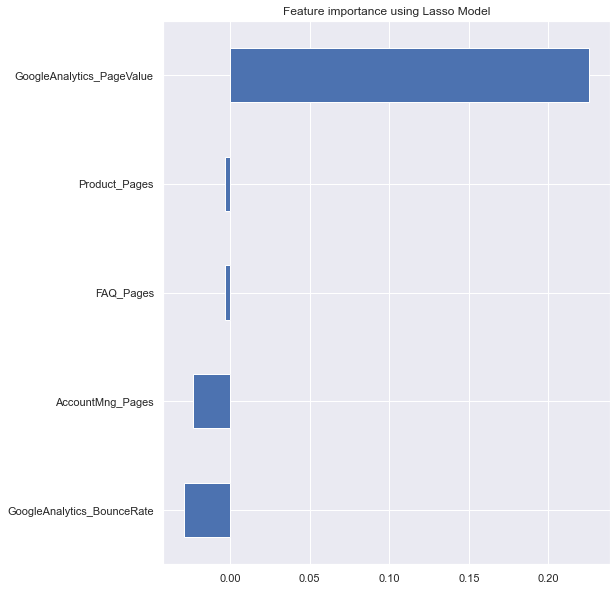

In [50]:
reg = LassoCV()

reg.fit(X_train_num_power, y_train)
coef = pd.Series(reg.coef_, index = X_train_num_power.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
plot_importance(coef,'Lasso')

In [51]:
X_train_model = X_train_power[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]
X_val_model = X_val_power[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]

# Create Model
model_log = LogisticRegression(class_weight='balanced').fit(X_train_model, y_train)

y_pred_train = model_log.predict(X_train_model)
y_pred_val = model_log.predict(X_val_model)

# evaluation:
print('f1_train:', f1_score(y_train, y_pred_train))
print('f1_val:', f1_score(y_val, y_pred_val))

f1_train: 0.6645367412140575
f1_val: 0.6524064171122994


In [52]:
X_train_model = X_train_power[['GoogleAnalytics_PageValue', 'Type_of_Traffic_12']]
X_val_model = X_val_power[['GoogleAnalytics_PageValue', 'Type_of_Traffic_12']]

# Create Model
model_log = LogisticRegression(class_weight='balanced').fit(X_train_model, y_train)

y_pred_train = model_log.predict(X_train_model)
y_pred_val = model_log.predict(X_val_model)

cm = confusion_matrix(y_val, y_pred_val)

# evaluation:
print(confusion_matrix(y_val, y_pred_val))
print('f1_train:', f1_score(y_train, y_pred_train))
print('f1_val:', f1_score(y_val, y_pred_val))

[[1869  243]
 [  83  305]]
f1_train: 0.663359319631467
f1_val: 0.6517094017094016


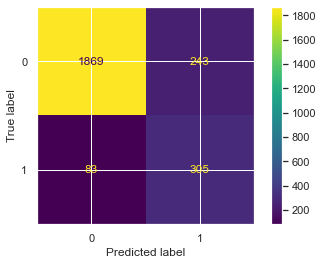

In [53]:
sns.set_style('darkgrid')
cm_display = ConfusionMatrixDisplay(cm).plot()

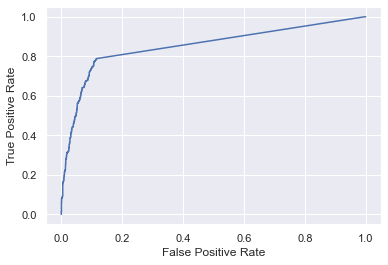

In [54]:
y_score = model_log.decision_function(X_val_model)

fpr, tpr, _ = roc_curve(y_val, y_score, pos_label=model_log.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

[[1865  247]
 [  82  306]]
precision: 0.5533453887884268
f1_val: 0.6503719447396386


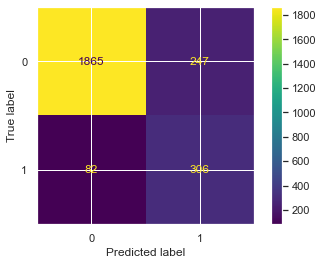

In [55]:
#low precision can be improved by increasing your threshold, making your model less sensitive
y_pred_new_threshold = (model_log.predict_proba(X_val_model)[:,1] > 0.2).astype(int)
y_pred_new_threshold

print(confusion_matrix(y_val, y_pred_new_threshold))
print('precision:', precision_score(y_val, y_pred_new_threshold))
print('f1_val:', f1_score(y_val, y_pred_new_threshold))

cm = confusion_matrix(y_val, y_pred_new_threshold)
cm_display = ConfusionMatrixDisplay(cm).plot()

- Oversampling

In [56]:
ros = RandomOverSampler(random_state=0)
X_train_power_over, y_train_over = ros.fit_resample(X_train_power, y_train)

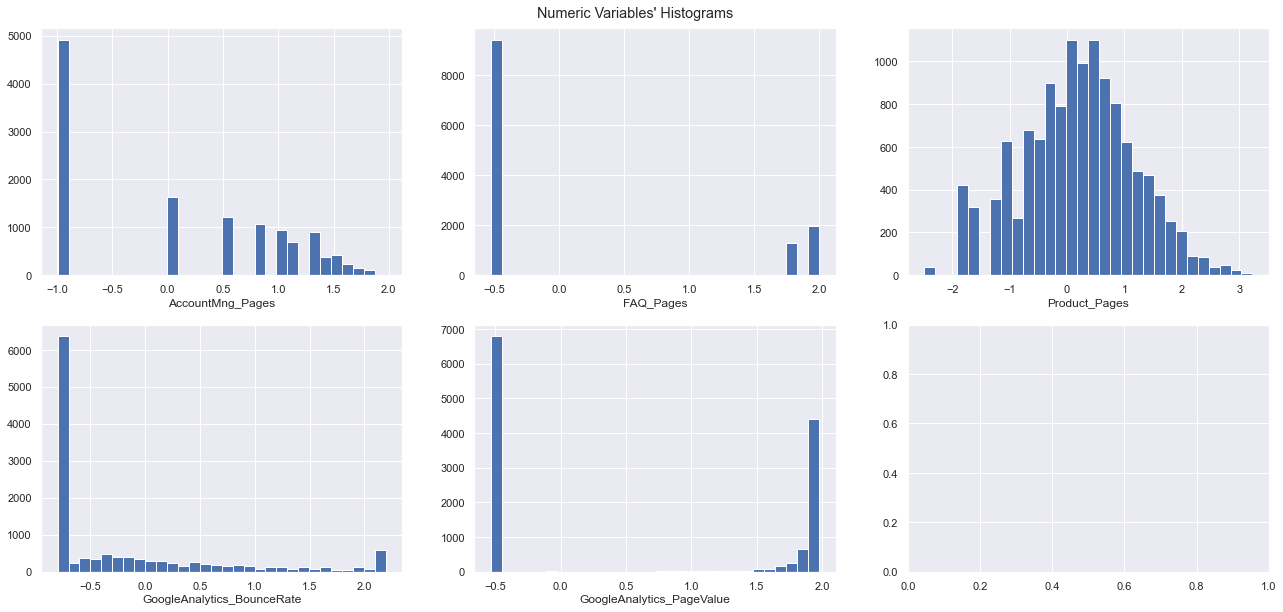

In [59]:
# After Oversampling
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(22, 10))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(X_train_power_over[feat], bins=30)
    ax.set_title(feat, y=-0.15)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title, y=0.91)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
plt.show()

In [57]:
X_train_model = X_train_power_over[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]
X_val_model = X_val_power[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]

# Create Model
model_log = LogisticRegression(class_weight='balanced').fit(X_train_model, y_train_over)

y_pred_train = model_log.predict(X_train_model)
y_pred_val = model_log.predict(X_val_model)

# evaluation:
print('f1_train:', f1_score(y_train_over, y_pred_train))
print('f1_val:', f1_score(y_val, y_pred_val))

f1_train: 0.8396971691902567
f1_val: 0.6524064171122994


In [58]:
X_train_model = X_train_power_over[['GoogleAnalytics_PageValue', 'Type_of_Traffic_12']]
X_val_model = X_val_power[['GoogleAnalytics_PageValue', 'Type_of_Traffic_12']]

# Create Model
model_log = LogisticRegression(class_weight='balanced').fit(X_train_model, y_train_over)

y_pred_train = model_log.predict(X_train_model)
y_pred_val = model_log.predict(X_val_model)

cm = confusion_matrix(y_val, y_pred_val)

# evaluation:
print('f1_train:', f1_score(y_train_over, y_pred_train))
print('f1_val:', f1_score(y_val, y_pred_val))

f1_train: 0.8393518137698445
f1_val: 0.6517094017094016


In [60]:
X_train_power.columns

Index(['AccountMng_Pages', 'FAQ_Pages', 'Product_Pages',
       'GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue',
       'OS_Chrome OS', 'OS_Fedora', 'OS_MacOSX', 'OS_Other', 'OS_Ubuntu',
       'OS_Windows', 'OS_iOS', 'Browser_2', 'Browser_3', 'Browser_4',
       'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
       'Browser_11', 'Browser_12', 'Browser_13', 'Type_of_Traffic_2',
       'Type_of_Traffic_3', 'Type_of_Traffic_4', 'Type_of_Traffic_5',
       'Type_of_Traffic_6', 'Type_of_Traffic_7', 'Type_of_Traffic_8',
       'Type_of_Traffic_9', 'Type_of_Traffic_10', 'Type_of_Traffic_11',
       'Type_of_Traffic_12', 'Type_of_Traffic_13', 'Type_of_Traffic_14',
       'Type_of_Traffic_15', 'Type_of_Visitor_Other',
       'Type_of_Visitor_Returner'],
      dtype='object')

## Logistic Regression

[[1870  242]
 [  83  305]]
f1_train: 0.6645367412140575
f1_val: 0.6524064171122994


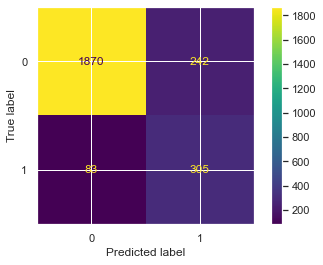

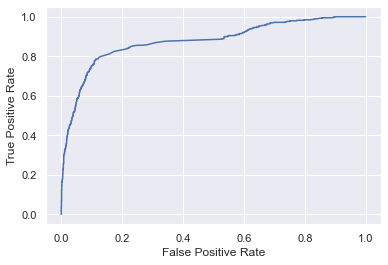

In [134]:
X_train_model = X_train_power[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'AccountMng_Pages',
                               'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]
X_val_model = X_val_power[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'AccountMng_Pages',
                           'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]

# Create Model
model_log = LogisticRegression(class_weight='balanced').fit(X_train_model, y_train)

y_pred_train = model_log.predict(X_train_model)
y_pred_val = model_log.predict(X_val_model)

cm = confusion_matrix(y_val, y_pred_val)

# evaluation:
print(cm)
print('f1_train:', f1_score(y_train, y_pred_train))
print('f1_val:', f1_score(y_val, y_pred_val))

cm_display = ConfusionMatrixDisplay(cm).plot()

y_score = model_log.decision_function(X_val_model)

fpr, tpr, _ = roc_curve(y_val, y_score, pos_label=model_log.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

[[1901  211]
 [  96  292]]
recall: 0.7525773195876289
precision: 0.5805168986083499
f1_val: 0.6554433221099888


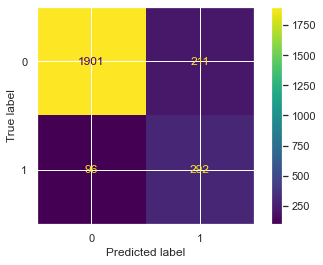

In [135]:
#low precision can be improved by increasing your threshold, making your model less sensitive
y_pred_new_threshold = (model_log.predict_proba(X_val_model)[:,1] > 0.79).astype(int)
y_pred_new_threshold

print(confusion_matrix(y_val, y_pred_new_threshold))
print('recall:', recall_score(y_val, y_pred_new_threshold))
print('precision:', precision_score(y_val, y_pred_new_threshold))
print('f1_val:', f1_score(y_val, y_pred_new_threshold))

cm = confusion_matrix(y_val, y_pred_new_threshold)
cm_display = ConfusionMatrixDisplay(cm).plot()

## Random Forest

In [136]:
def calculate_F1_rf(interval, parameter, max_depth = None):
    train_results = []
    test_results = []
       
    for value in interval:
        rf = RandomForestClassifier(max_depth = value, class_weight='balanced', random_state=5)
        rf.fit(X_train_model, y_train)
        train_pred = rf.predict(X_train_model)
        f1_train = f1_score(y_train, train_pred)
        train_results.append(f1_train)
        
        val_pred = rf.predict(X_val_model)
        f1_val = f1_score(y_val, val_pred)
        test_results.append(f1_val)
            
    print('The best f1 score for train is ' + str(max(train_results)) + ' for the depth of ' + str(train_results.index(max(train_results))+1))
    print('The best f1 score for test is ' + str(max(test_results)) + ' for the depth of ' + str(test_results.index(max(test_results))+1))
        
    
    plt.plot(interval, train_results, label = "Train F1")
    plt.plot(interval, test_results, label = "Val F1")
    plt.xticks(interval)
    plt.legend()
    plt.ylabel("F1 score")
    plt.xlabel(str(parameter))
    plt.show()

The best f1 score for train is 0.91273374888691 for the depth of 18
The best f1 score for test is 0.6559485530546624 for the depth of 6


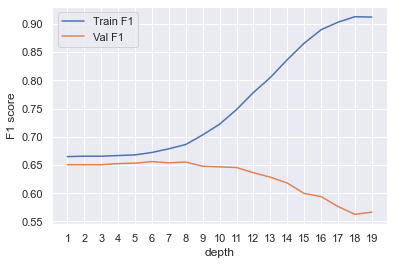

In [137]:
calculate_F1_rf(np.arange(1,20), 'depth')

[[1873  239]
 [  82  306]]
f1_train: 0.6721369960756333
f1_val: 0.6559485530546624


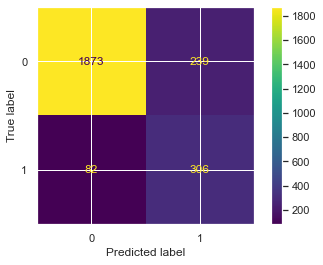

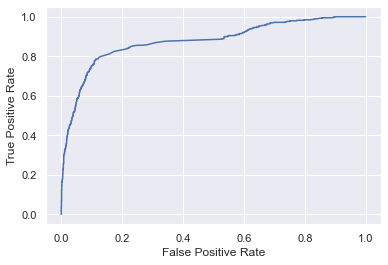

In [138]:
# Create Model
model_rf = RandomForestClassifier(max_depth = 6, class_weight='balanced', random_state=5).fit(X_train_model, y_train)

y_pred_train = model_rf.predict(X_train_model)
y_pred_val = model_rf.predict(X_val_model)

cm = confusion_matrix(y_val, y_pred_val)

# evaluation:
print(cm)
print('f1_train:', f1_score(y_train, y_pred_train))
print('f1_val:', f1_score(y_val, y_pred_val))

cm_display = ConfusionMatrixDisplay(cm).plot()

y_score = model_log.decision_function(X_val_model)

fpr, tpr, _ = roc_curve(y_val, y_score, pos_label=model_log.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

[[1911  201]
 [ 100  288]]
recall: 0.7422680412371134
precision: 0.588957055214724
f1_val: 0.6567844925883695


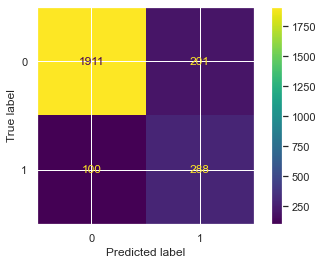

In [139]:
#low precision can be improved by increasing your threshold, making your model less sensitive
y_pred_new_threshold = (model_rf.predict_proba(X_val_model)[:,1] > 0.69).astype(int)
y_pred_new_threshold

print(confusion_matrix(y_val, y_pred_new_threshold))
print('recall:', recall_score(y_val, y_pred_new_threshold))
print('precision:', precision_score(y_val, y_pred_new_threshold))
print('f1_val:', f1_score(y_val, y_pred_new_threshold))

cm = confusion_matrix(y_val, y_pred_new_threshold)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [153]:
X_train_model.to_csv('dataset_10dec2021\X_train.csv')

In [155]:
y_train.to_csv('dataset_10dec2021\y_train.csv')

In [156]:
X_val_model.to_csv('dataset_10dec2021\X_val.csv')

In [157]:
y_val.to_csv('dataset_10dec2021\y_val.csv')

In [158]:
# # TEST Create Model

# X_train_model = X_train[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'AccountMng_Pages',
#                                'Type_of_Traffic', 'Type_of_Visitor']]
# X_val_model = X_val[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'AccountMng_Pages',
#                            'Type_of_Traffic', 'Type_of_Visitor']]

# # create dummy variables - 'OS', 'Browser', 'Type_of_Traffic', 'Type_of_Visitor' - Train Dataset
# # 'Type_of_Traffic'
# X_train_model = pd.get_dummies(X_train_model, columns = ['Type_of_Traffic'], drop_first=True)
# X_val_model = pd.get_dummies(X_val_model, columns = ['Type_of_Traffic'], drop_first=True)

# # 'Type_of_Visitor'
# X_train_model = pd.get_dummies(X_train_model, columns = ['Type_of_Visitor'], drop_first=True)
# X_val_model = pd.get_dummies(X_val_model, columns = ['Type_of_Visitor'], drop_first=True)


# # final test dataset
# X_train_model = X_train_model[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'AccountMng_Pages',
#                            'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]
# X_val_model = X_val_model[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'AccountMng_Pages',
#                            'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]

# model_rf = RandomForestClassifier(max_depth = 6, class_weight='balanced', random_state=5).fit(X_train_model, y_train)

# y_pred_train = model_rf.predict(X_train_model)
# y_pred_val = model_rf.predict(X_val_model)

# cm = confusion_matrix(y_val, y_pred_val)

# # evaluation:
# print(cm)
# print('f1_train:', f1_score(y_train, y_pred_train))
# print('f1_val:', f1_score(y_val, y_pred_val))

# cm_display = ConfusionMatrixDisplay(cm).plot()

# y_score = model_log.decision_function(X_val_model)

# fpr, tpr, _ = roc_curve(y_val, y_score, pos_label=model_log.classes_[1])
# roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [159]:
# #low precision can be improved by increasing your threshold, making your model less sensitive
# y_pred_new_threshold = (model_rf.predict_proba(X_val_model)[:,1] > 0.58).astype(int)
# y_pred_new_threshold

# print(confusion_matrix(y_val, y_pred_new_threshold))
# print('recall:', recall_score(y_val, y_pred_new_threshold))
# print('precision:', precision_score(y_val, y_pred_new_threshold))
# print('f1_val:', f1_score(y_val, y_pred_new_threshold))

# cm = confusion_matrix(y_val, y_pred_new_threshold)
# cm_display = ConfusionMatrixDisplay(cm).plot()

In [160]:
# #testing bagging

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.ensemble import BaggingClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold

# # define model
# model_bg = BaggingClassifier()

# # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# X_train_model = X_train_power[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'AccountMng_Pages',
#                                'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]
# X_val_model = X_val_power[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'AccountMng_Pages',
#                            'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]


# # concat train + val
# X_model = pd.concat([X_train_model, X_val_model])
# y = pd.concat([y_train, y_val])


# # evaluate model
# scores = cross_val_score(model_bg, X_model, y, scoring='f1', cv=cv, n_jobs=-1)


# # summarize performance
# print('Mean f1: %.3f' % mean(scores))

## Dataset for test

In [140]:
test_set = pd.read_csv('data/test.csv')
test_set.drop(['AccountMng_Duration', 'FAQ_Duration', 'Product_Duration', 'GoogleAnalytics_ExitRate'], axis=1, inplace=True)

In [141]:
test_set.columns

Index(['Access_ID', 'Date', 'AccountMng_Pages', 'FAQ_Pages', 'Product_Pages',
       'GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'OS',
       'Browser', 'Country', 'Type_of_Traffic', 'Type_of_Visitor'],
      dtype='object')

In [142]:
# define new metric and non-metric features
# Define metric and non-metric features
non_metric_features = ['Access_ID', 'Date', 'OS', 'Browser', 'Country', 'Type_of_Traffic', 'Type_of_Visitor']
metric_features = test_set.columns.drop(non_metric_features).to_list()

In [143]:
# Separate metric and non-metric features before scaling
# Test dataset
test_num = test_set[metric_features]
test_cat = test_set[non_metric_features]

# transform test dataset
test_num_power = power.transform(test_num)

# Convert the array to a pandas dataframe
test_num_power = pd.DataFrame(test_num_power, columns = test_num.columns).set_index(test_num.index)

# concat numeric and categorical data after Power Transformation - val dataset
test_power = pd.concat([test_num_power, test_cat], axis=1)

# create dummy variables - 'OS', 'Browser', 'Type_of_Traffic', 'Type_of_Visitor' - Train Dataset
# 'Type_of_Traffic'
test_power = pd.get_dummies(test_power, columns = ['Type_of_Traffic'], drop_first=True)

# 'Type_of_Visitor'
test_power = pd.get_dummies(test_power, columns = ['Type_of_Visitor'], drop_first=True)

# final test dataset
test_power = test_power[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_PageValue', 'AccountMng_Pages',
                           'Type_of_Traffic_12', 'Type_of_Visitor_Returner']]

In [144]:
test_power

GoogleAnalytics_BounceRate  GoogleAnalytics_PageValue  AccountMng_Pages  \
0                       0.381579                  -0.532968         -0.994652   
1                      -0.670728                  -0.532968          0.551204   
2                      -0.798198                  -0.532968         -0.994652   
3                      -0.798198                  -0.532968         -0.994652   
4                      -0.650031                   1.065180          1.649087   
...                          ...                        ...               ...   
2295                   -0.320718                  -0.532968          1.560637   
2296                    1.910405                  -0.532968         -0.994652   
2297                   -0.798198                   1.891936          0.551204   
2298                    0.554438                  -0.532968          1.444152   
2299                    0.807580                  -0.532968          0.076531   

      Type_of_Traffic_12  Type_of_Visitor_Returner  
0                      0                         1  
1                      0                         1  
2                      0                         1  
3                      0                         0  
4                      0                         1  
...                  ...                       ...  
2295                   0                         1  
2296                   0                         1  
2297                   0                         1  
2298                   0                         1  
2299                   0                         1  

[2300 rows x 5 columns]

In [147]:
#Random Forest
y_pred_test = model_rf.predict(test_power)
y_pred_new_threshold = (model_rf.predict_proba(test_power)[:,1] > 0.69).astype(int)

print(y_pred_new_threshold.shape)

df_submission = pd.concat([test_set['Access_ID'], pd.DataFrame(columns=['Buy'], data=y_pred_new_threshold)], axis=1)

df_submission

(2300,)


Access_ID  Buy
0     798519314    0
1     798663101    0
2     798663221    0
3     798760918    0
4     798856982    0
...         ...  ...
2295  962042726    0
2296  962063064    0
2297  962147749    1
2298  962182167    0
2299  962218682    0

[2300 rows x 2 columns]

In [148]:
df_submission.to_csv('random_forest_6depth_power_new_threshold.csv', index=False)